In [155]:
# Data Management/Investigation
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import country_converter as coco

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m
from sklearn.inspection import permutation_importance

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#Tag Management
from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import PDFExporter
from nbconvert.preprocessors import TagRemovePreprocessor

In [156]:
c = Config()

# Configure our tag removal
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled=True

# # Configure and run out exporter
# c.PDFExporter.preprocessors = ["TagRemovePreprocessor"]

In [157]:
#Imported 2001 fractionalization dataset & dropping 5 rows
frac_2001 = pd.read_excel(r'Datasets/2003_fractionalization.xls').drop([0,1,217,218,219])

#Renamed the columns
frac_2001.columns = ['Temp_Country', 'Source (Ethnicity Data)', 'Date (Ethnicity Data)', 'Ethnic', 'ELF', 'Religion']

#Replaced rows with value '.' to 'NaN'
frac_2001 = frac_2001.replace('.', 'NaN')

#Dropped specific columns
frac_2001 = frac_2001.drop(columns = ['Source (Ethnicity Data)', 'Date (Ethnicity Data)', 'Ethnic', 'Religion']).reset_index(drop = True)

#Inserted a row 
frac_2001.insert(1, "Year", "2001")

Columns 6 and 9 report an ELF Index (for 1961 and 1985, respectively) that uses none of the groupings reported in the sources when data on sub-groups are available.  (For example, it treats separate Native American groups as separate ethnic groups rather than combining these in a catch-all "Indigenous Peoples".  Similarly,  it treats  Hutus and Tutsis as separate ethnic groups rather than grouping these as  Banyarwanda in Rwanda or Barundi in Burundi). In addition, in settler societies of the Western Hemisphere, this index treats racial distinctions within ethnolinguistic groups (Afro-Americans versus White Americans or Afro-Colombians versus Euro-Colombians) as separate ethnic groups.

In [158]:
#Imported 1961 and 1985 fractionalization dataset
frac_6185 = pd.read_excel(r'Datasets/fractionalization_2000.xls').drop([0]).reset_index(drop = True)

#Dropped more columns 
frac_6185 = frac_6185.drop(columns = [1, 3, 4, 5, 7, 8, 10, 11, 12])

#Renamed the columns
frac_6185.columns = ['Temp_Country', '1961', '1985']

#Melted the dataframe
frac_6185 = pd.melt(frac_6185, id_vars=['Temp_Country'])

#Renamed the columns
frac_6185.columns = ['Temp_Country', 'Year', 'ELF']

In [159]:
#Imported the World Bank Infant Mortality Dataset
IMD = pd.read_excel(r'Datasets/IMR.xls')

#Imported the World Bank Rural Dataset
rural = pd.read_excel(r'Datasets/rural.xls')

#Imported the World Bank Urban Dataset
urban = pd.read_excel(r'Datasets/urban.xls')

#Imported the World Bank Migration Dataset
migration = pd.read_excel(r'Datasets/migration.xls')

#Imported the World Bank GDP Dataset
GDP = pd.read_excel(r'Datasets/GDP.xls')

#Imported the World Bank Cereal Dataset
cereal = pd.read_excel(r'Datasets/cereal.xls')

Without going into too much detail, since this is an Excel file that I uploaded into Python there was a lot of data clean that needed to be done, namely, renaming the columns and dropping all the columns that I was not interested in. I discovered that the actual column names were in the 3rd row of the dataset so converted that row into a list, changed the datatype for the float values into int, and then renamed the columns.

In [160]:
#Created a world bank function that converts all the world bank data into a similar format 
def world_bank(df):
    '''
    Function that takes a World Bank dataframe and adds the appropriate column headings for the pertinent columns.
    This function also drops any columns that are not pertinent to the research questions.

    Args:
        df (dataframe): unedited World Bank dataframe
        
    Returns:
        DataFrame: edited dataframe with the correct columns
    '''
    names = []
    for x in df.iloc[2]: #Created a for loop that created a list of columns names from the 3rd row and change the datatype as appropriate
        if isinstance(x, str):
            names.append(x)
        elif isinstance(x, float):
            y = x.astype(int)
            names.append(y)
    df.columns = names
    notdrop = ['Country Name', 1961, 1985, 2001] #Created a list of the column names I am interested in
    for x in df.columns: #Dropped all columns that were not in 'notdrop' list
        if x not in notdrop:
            df = df.drop(columns = [x])
    df.columns = ['Temp_Country', '1961', '1985', '2001'] #Renamed the columns
    df = df.drop([0,1,2]) #Dropped rows
    df = pd.melt(df, id_vars=['Temp_Country']) #Melted the table into the format I was interested in
    return df

I also noticed that with the migration dataset the data was fairly sporatic with measurements happening every 5 years starting from 1962. As such, I am using data from 1962, 1987 and 2002 to be representative for the migration patterns in 1961, 1985, and 2001 as the margin of error should be fairly low.

In [161]:
#Created a world bank function that converts all the world bank data into a similar format 
def wb_migration(df_2):
    '''
    Function that takes a World Bank Migration dataframe and adds the appropriate column headings for the pertinent columns.
    This function also drops any columns that are not pertinent to the research questions. This function is different 
    than the above function as the Migration dataset has measurements happening every 5 years starting from 1962. 
    As such, I am using data from 1962, 1987 and 2002 to be representative for the migration patterns in 1961, 1985, 
    and 2001.

    Args:
        df (dataframe): unedited World Bank Migration dataframe
        
    Returns:
        DataFrame: edited Migration dataframe with the correct columns
    '''
    names_2 = []
    for z in df_2.iloc[2]: #Created a for loop that created a list of columns names from the 3rd row and change the datatype as appropriate
        if isinstance(z, str):
            names_2.append(z)
        elif isinstance(z, float):
            w = z.astype(int)
            names_2.append(w)
    df_2.columns = names_2
    notdrop_2 = ['Country Name', 1962, 1987, 2002] #Created a list of the column names I am interested in
    for z in df_2.columns: #Dropped all columns that were not in 'notdrop' list
        if z not in notdrop_2:
            df_2 = df_2.drop(columns = [z])
    df_2.columns = ['Temp_Country', '1961', '1985', '2001'] #Renamed the columns
    df_2 = df_2.drop([0,1,2]) #Dropped rows
    df_2 = pd.melt(df_2, id_vars=['Temp_Country']) #Melted the table into the format I was interested in
    return df_2

In [162]:
#Ran the world_bank function for the World Bank datasets and renamed the columns as appropriate
IMD = world_bank(IMD)
IMD.columns = ['Temp_Country', 'Year', 'IMR']

rural = world_bank(rural)
rural.columns = ['Temp_Country', 'Year', 'Rural_%']

urban = world_bank(urban)
urban.columns = ['Temp_Country', 'Year', 'Urban_%']

GDP = world_bank(GDP)
GDP.columns = ['Temp_Country', 'Year', 'GDP']

cereal = world_bank(cereal)
cereal.columns = ['Temp_Country', 'Year', 'Cereal_Yield']

In [163]:
#Ran the migration function for the World Bank migration dataset and renamed the columns as appropriate
migration = wb_migration(migration)
migration.columns = ['Temp_Country', 'Year', 'Migration']

In [164]:
#Imported the Barro educational attainment dataset
education = pd.read_excel(r'Datasets/BL2013_F_v2.2.xls').drop(range(13))

#Dropped Columns 
education = education.drop(columns = ['Unnamed: 4',
                                      'Unnamed: 5',
                                      'Unnamed: 6',
                                      'Unnamed: 7',
                                      'Unnamed: 9',
                                      'Unnamed: 10',
                                      'Unnamed: 11',
                                      'Unnamed: 12',
                                      'Unnamed: 13',
                                      'Unnamed: 14',
                                      'Unnamed: 15',
                                      'Unnamed: 16'])

I know from looking at the excel that columns *Unnamed: 2* and *Unnamed: 3* represent the age groups with *Unnamed: 2* being the min age and *Unnamed: 3* being the max age. I also noticed that when the age group was (15-19) there was a country name in *Unnamed: 0* but the age range that I'm interested in is from (15-999). As such, I deleted all the rows except for those two.

In [165]:
#Dropped the rows with the age ranges that I wasn't looking at
education = education[(education["Unnamed: 2"] == 15) & (education["Unnamed: 3"] == 999) | (education["Unnamed: 3"] == 19)].reset_index(drop = True)

In [166]:
#Created a for loop replacing the NaN country values with the appropriate country name 
for x in range(3796):
    if isinstance(education.iloc[x,0], str): #Assigned a value to cname if the cell had a string value
        cname = education.iloc[x,0]
    else: 
        education.loc[x,'Unnamed: 0'] = cname #Replaced NaN with the country name

Also I realized that this education dataset happened in 5 year increments starting from 1950 and, as such, I'm using data from 1960, 1985, and 2000 as representative of 1961, 1985, and 2001.

In [167]:
#Dropped the rows with the years I wasn't looking at
education = education[(education["Unnamed: 1"] == 1960) | (education["Unnamed: 1"] == 1985) | (education["Unnamed: 1"] == 2000)]

#Dropped the age range I wasn't look at
education = education[(education["Unnamed: 2"] == 15) & (education["Unnamed: 3"] == 999)]

#Dropped columns 
education = education.drop(columns = ['Unnamed: 2','Unnamed: 3'])

#Replaced the years
education = education.replace([1960, 1985, 2000], [1961, 1985, 2001]).reset_index(drop = True)

#Renamed the columns
education.columns = ['Temp_Country', 'Year', 'Education']

In [168]:
#Changed the datatypes 
IMD['Year'] = IMD['Year'].astype(int)
frac_2001['Year'] = frac_2001['Year'].astype(int)
frac_6185['Year'] = frac_6185['Year'].astype(int)
frac_2001['ELF'] = frac_2001['ELF'].astype(float)
frac_6185['ELF'] = frac_6185['ELF'].astype(float)
rural['Year'] = rural['Year'].astype(int)
urban['Year'] = urban['Year'].astype(int)
GDP['Year'] = GDP['Year'].astype(int)
migration['Year'] = migration['Year'].astype(int)
cereal['Year'] = cereal['Year'].astype(int)

In [169]:
#Country-converter variable to restrict the set to only the official recognized UN members
cc_UN = coco.CountryConverter(only_UNmember=True)

In [170]:
def un_only(dta): 
    '''
    Function that takes a dataframe with countries and passes it through the country_converter package to remove any 
    non-UN countries from the dataframe. 

    Args:
        dta (dataframe): dataframe with a column of countries 
        
    Returns:
        DataFrame: frame containing scraped tables
    '''
    UN_list = dta.Temp_Country.tolist() #Created a new list from the Country column of the inputted dataset
    UN = cc_UN.convert(UN_list, to = 'name_short') #Ran cc_UN on the dataset and saved that list as 'UN'
    dta = dta.drop(columns = "Temp_Country") #Dropped the 'Temp_Country' column from the dataframe
    dta["Country"] = UN #Created a new column called 'Country' and set those values as 'UN'
    dta = dta.set_index('Country') #Set the index as the 'Country' column
    dta = dta.drop(index = "not found") #Set the index as the 'Country' column
    dta = dta.reset_index() #Reset the index in order to remove the 'Country' column as the index
    return dta

In [171]:
#Passed the datasets into 'un_only' and resaved the datasets
IMD = un_only(IMD)
frac_2001 = un_only(frac_2001)
frac_6185 = un_only(frac_6185)
rural = un_only(rural)
urban = un_only(urban)
migration = un_only(migration)
GDP = un_only(GDP)
education = un_only(education)
cereal = un_only(cereal)

Aruba not found in regex
Arab World not found in regex
American Samoa not found in regex
Bermuda not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
Curacao not found in regex
Cayman Islands not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Faroe Islands not found in regex
Gibraltar not found in regex
Greenland not found in regex
Guam not found in regex
High income not found in regex
Hong Kong SAR, China not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in re

Upper middle income not found in regex
British Virgin Islands not found in regex
Virgin Islands (U.S.) not found in regex
World not found in regex
Kosovo not found in regex
American Samoa not found in regex
Aruba not found in regex
Bermuda not found in regex
Faroe Islands not found in regex
French Guiana  not found in regex
French Polynesia not found in regex
Gaza Strip not found in regex
Greenland not found in regex
Guadeloupe not found in regex
Guam not found in regex
Hong Kong not found in regex
Isle of Man not found in regex
Jersey not found in regex
Macau not found in regex
Martinique not found in regex
Mayotte not found in regex
Netherlands Antilles not found in regex
New Caledonia not found in regex
Northern Mariana Islands not found in regex
Puerto Rico not found in regex
Reunion not found in regex
Serbia/Montenegro (Yugoslavia) not found in regex
Taiwan not found in regex
Virgin Islands (U.S.) not found in regex
West Bank not found in regex
Yugoslavia (pre 1991) not found in r

IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Isle of Man not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Macao SAR, China not found in regex
St. Martin (French part) not found in regex
Middle East & North Africa not found in regex
Middle income not found in regex
Middle East & North Africa ( not found in regex
Northern Mariana Islands not found in regex
North America not found in regex
New Caledonia not found in regex
OECD members not found in regex
Other small states not found in regex
Pre-demographic dividend not found in regex
Puerto Rico not found in regex
West Bank and

Gibraltar not found in regex
Greenland not found in regex
Guam not found in regex
High income not found in regex
Hong Kong SAR, China not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Isle of Man not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Macao SAR, China not found in regex
St. Martin (French part) not found in regex
Middle East & North Africa not found in regex
Middle income not found in regex
Middle East & North Africa ( not found in regex
Northern Mariana Islands not found in regex
North America

Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Faroe Islands not found in regex
Gibraltar not found in regex
Greenland not found in regex
Guam not found in regex
High income not found in regex
Hong Kong SAR, China not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Isle of Man not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Macao SAR, China not found in regex
St. Martin (French part) not fo

Cayman Islands not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Faroe Islands not found in regex
Gibraltar not found in regex
Greenland not found in regex
Guam not found in regex
High income not found in regex
Hong Kong SAR, China not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Isle of Man not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not fo

Europe & Central Asia (IDA & IBRD countries) not found in regex
Latin America & the Caribbean (IDA & IBRD countries) not found in regex
Middle East & North Africa (IDA & IBRD countries) not found in regex
South Asia (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD countries) not found in regex
Upper middle income not found in regex
British Virgin Islands not found in regex
Virgin Islands (U.S.) not found in regex
World not found in regex
Kosovo not found in regex
Aruba not found in regex
Arab World not found in regex
American Samoa not found in regex
Bermuda not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
Curacao not found in regex
Cayman Islands not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro

In [172]:
#Changing Rural, Urban, GDP, and Education into decimal values 
rural['Rural_%'] *= 0.01
urban['Urban_%'] *= 0.01
GDP['GDP'] *= 0.01
education['Education'] *= 0.01

#Converting IMD into a percentage
IMD['IMR'] /= 1000

In [173]:
#Outer merged the globalization factors to the frac_2001 dataset 
a = pd.merge(IMD, frac_2001, on = ['Country', 'Year'], how = 'outer')
b = pd.merge(a, rural, on = ['Country', 'Year'], how = 'outer')
c = pd.merge(b, migration, on = ['Country', 'Year'], how = 'outer') 
d = pd.merge(c, GDP, on = ['Country', 'Year'], how = 'outer')
e = pd.merge(d, urban, on = ['Country', 'Year'], how = 'outer')
f = pd.merge(e, cereal, on = ['Country', 'Year'], how = 'outer')
frac_2001 = pd.merge(f, education, on = ['Country', 'Year'], how = 'outer')

In [174]:
#Included only 2001 data for frac_2001
frac_2001 = frac_2001[frac_2001.Year == 2001].reset_index(drop = True)

In [175]:
#Outer merged the globalization factors to the frac_6185 dataset 
g = pd.merge(IMD, frac_6185, on = ['Country', 'Year'], how = 'outer')
h = pd.merge(g, rural, on = ['Country', 'Year'], how = 'outer')
i = pd.merge(h, migration, on = ['Country', 'Year'], how = 'outer') 
j = pd.merge(i, GDP, on = ['Country', 'Year'], how = 'outer')
k = pd.merge(j, urban, on = ['Country', 'Year'], how = 'outer')
l = pd.merge(k, cereal, on = ['Country', 'Year'], how = 'outer')
frac_6185 = pd.merge(l, education, on = ['Country', 'Year'], how = 'outer')

In [176]:
#Included only 1961 & 1985 data for frac_6185
frac_6185 = frac_6185[frac_6185.Year != 2001]

In [177]:
#Outer merged both fractionalization datasets 
frac = pd.merge(frac_2001, frac_6185, on = ['Country', 'Year', 'ELF', 'Rural_%', 'Urban_%', 'IMR', 'Migration', 'GDP', 'Cereal_Yield', 'Education'], how = 'outer')

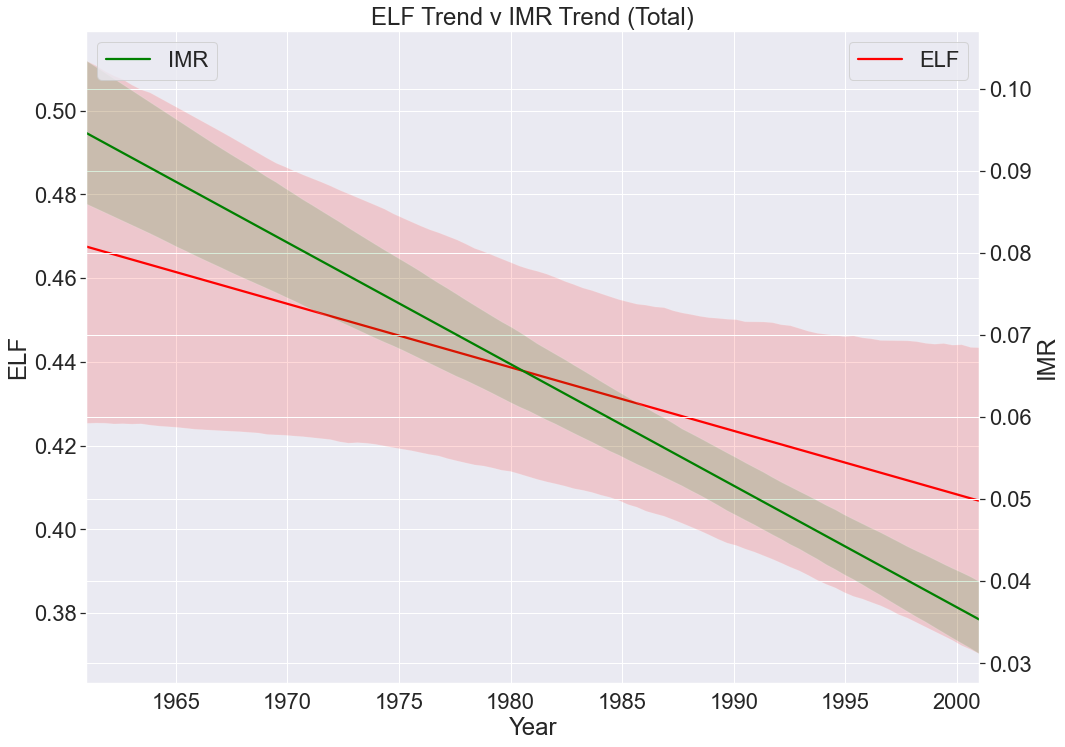

In [178]:
#Created a dual regression plot to compare the trends of both variables across 1961, 1985, and 2001
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(16, 12))
sns.regplot(x="Year", y= "ELF", data = frac, color = 'red', ax = ax, scatter = False , label = "ELF").set_title("ELF Trend v IMR Trend (Total)")
ax.legend(loc= 1)
ax2 = ax.twinx()
sns.regplot(x="Year", y= "IMR", data = frac, color = 'green', ax = ax2, scatter = False, label = "IMR");
ax2.legend(loc = 2);

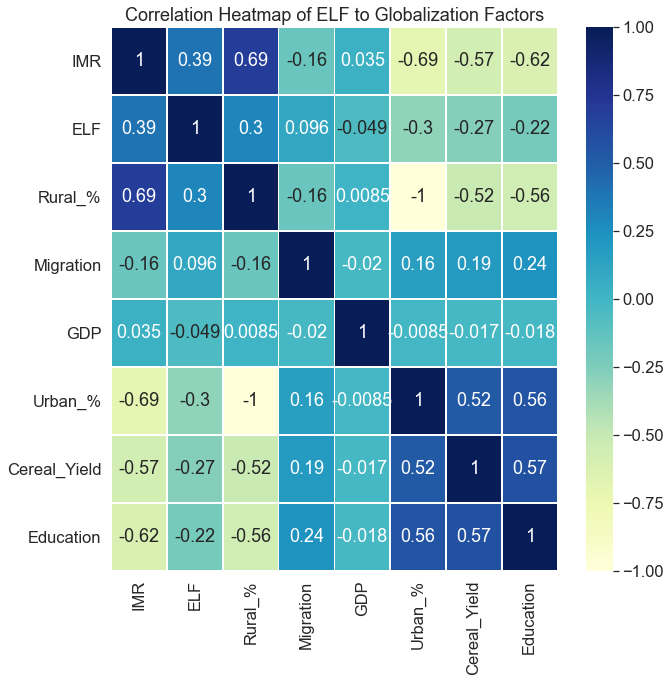

In [179]:
#Created a variable that only selected the float datatype and calculated the respective correlation
frac_corr = frac_6185.select_dtypes(include=['float64']).corr()

#Plotted the "frac_corr" variable by creating a correlation heatmaps
sns.set(font_scale = 1.5)
plt.figure(figsize = (10,10));
sns.heatmap(frac_corr, center=0, linewidths=.5, cmap = "YlGnBu", annot=True)#Used the 'annot' value to provide the exact correlation values
plt.title ('Correlation Heatmap of ELF to Globalization Factors');

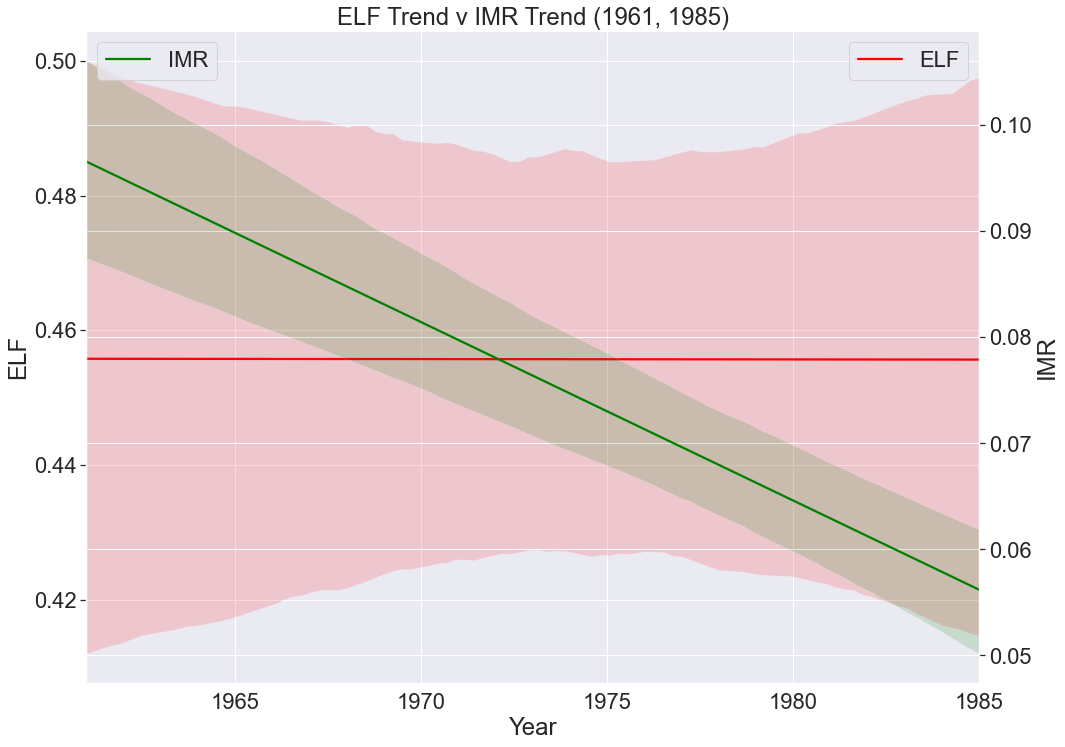

In [180]:
#Created a dual regression plot to compare the trends of both variables across 1961, and 1985
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(16, 12))
sns.regplot(x="Year", y= "ELF", data = frac_6185, color = 'red', ax = ax, scatter = False, label = "ELF").set_title("ELF Trend v IMR Trend (1961, 1985)")
ax.legend(loc= 1)
ax2 = ax.twinx()
sns.regplot(x="Year", y= "IMR", data = frac_6185, color = 'green', ax = ax2, scatter = False, label = "IMR");
ax2.legend(loc = 2);

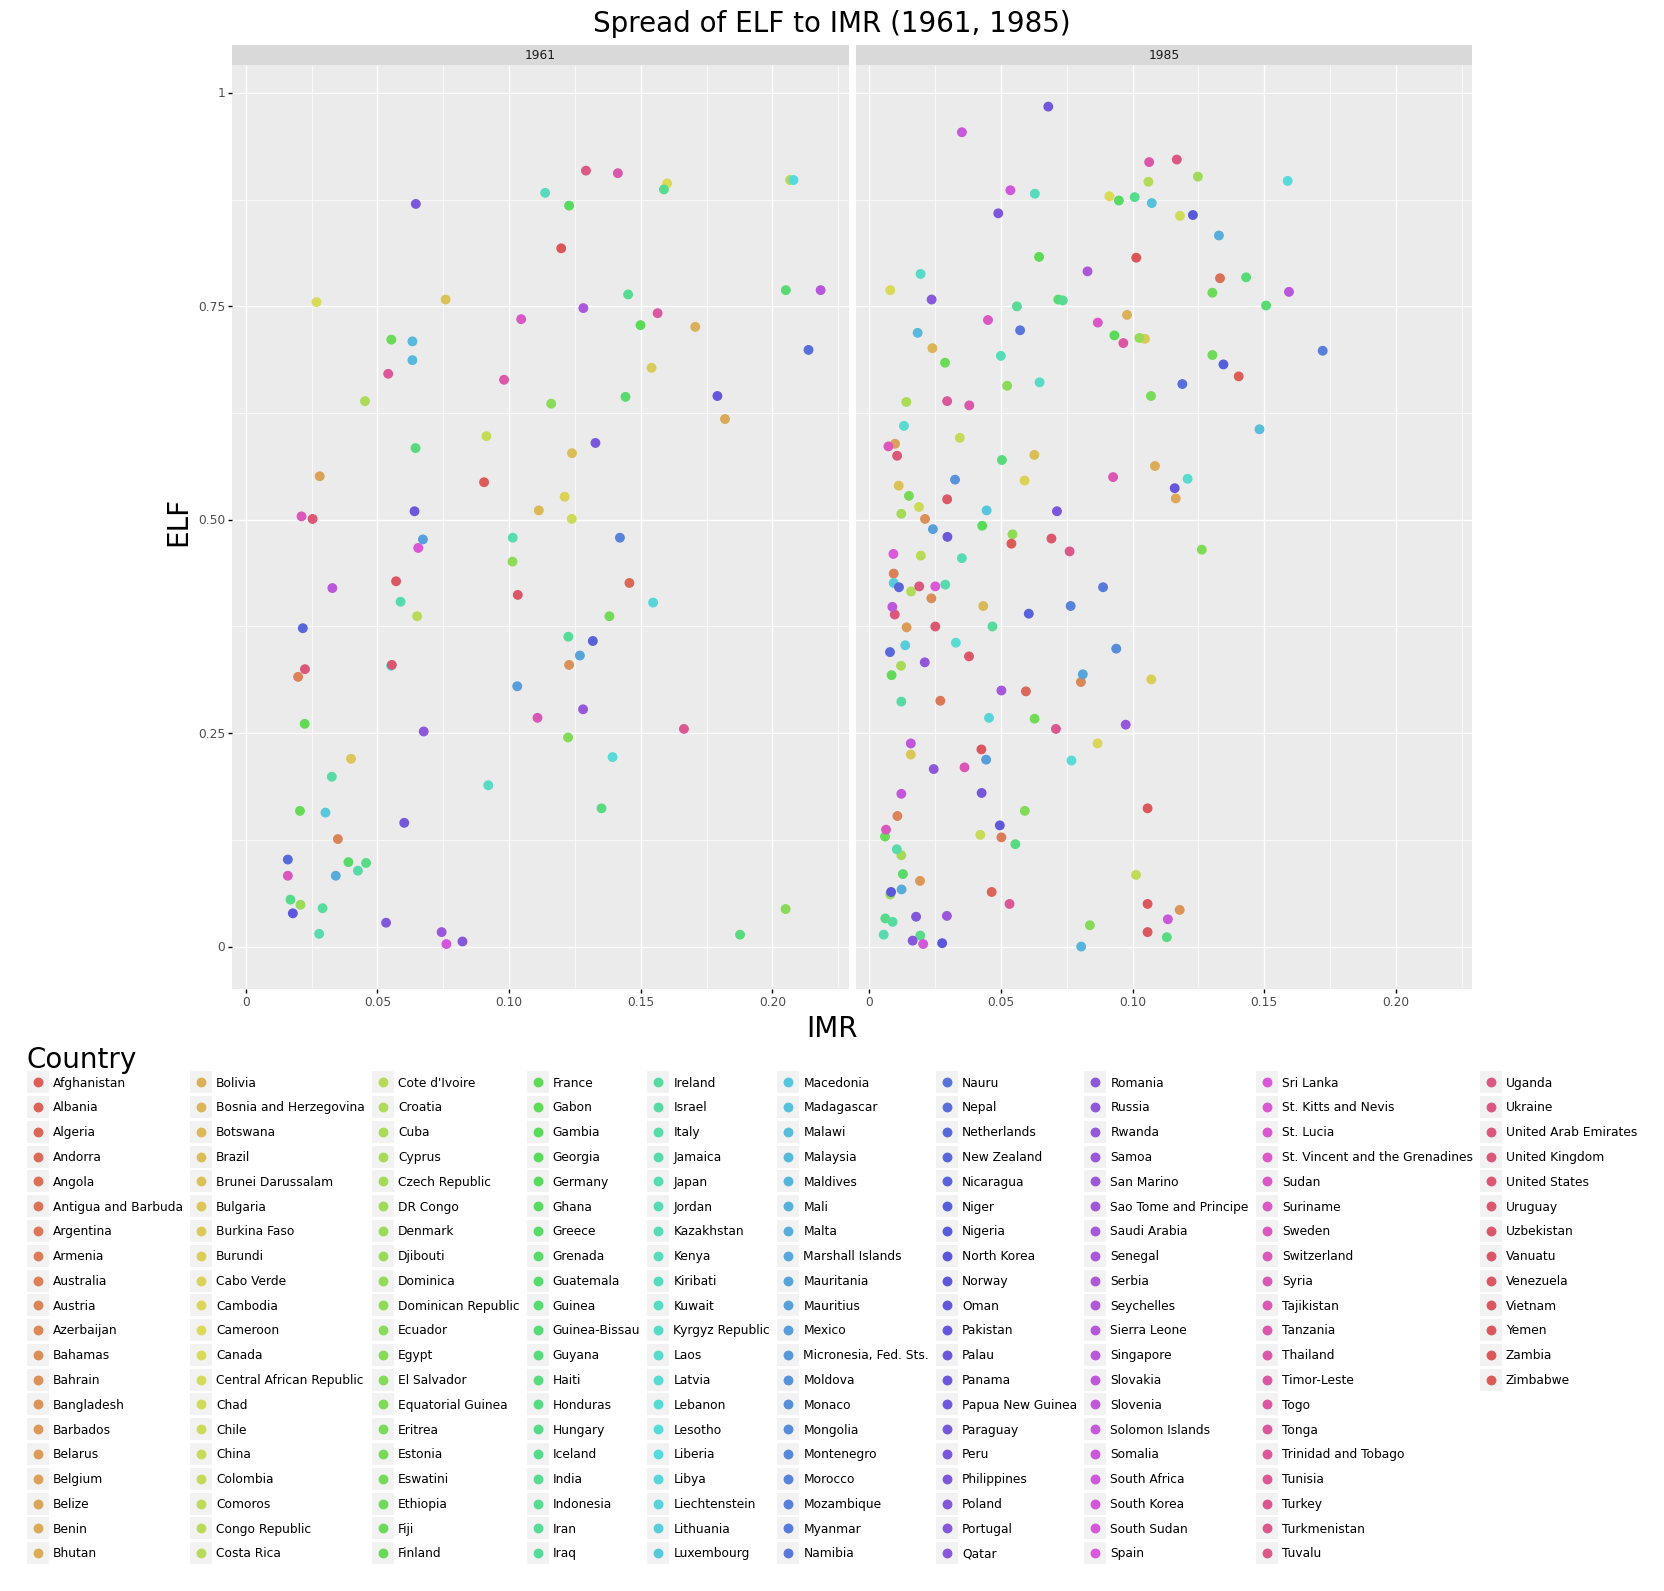

<ggplot: (322134348)>

In [181]:
#Random ggplot I ended up not using
(ggplot(frac_6185, aes(x='IMR', y='ELF', color = "Country")) +
geom_point(size = 3) +
facet_wrap(['Year']) +
labs(title="Spread of ELF to IMR (1961, 1985)") +
theme(legend_position = (0.5, -0.15), figure_size=(16, 12), title=element_text(size = 20)))

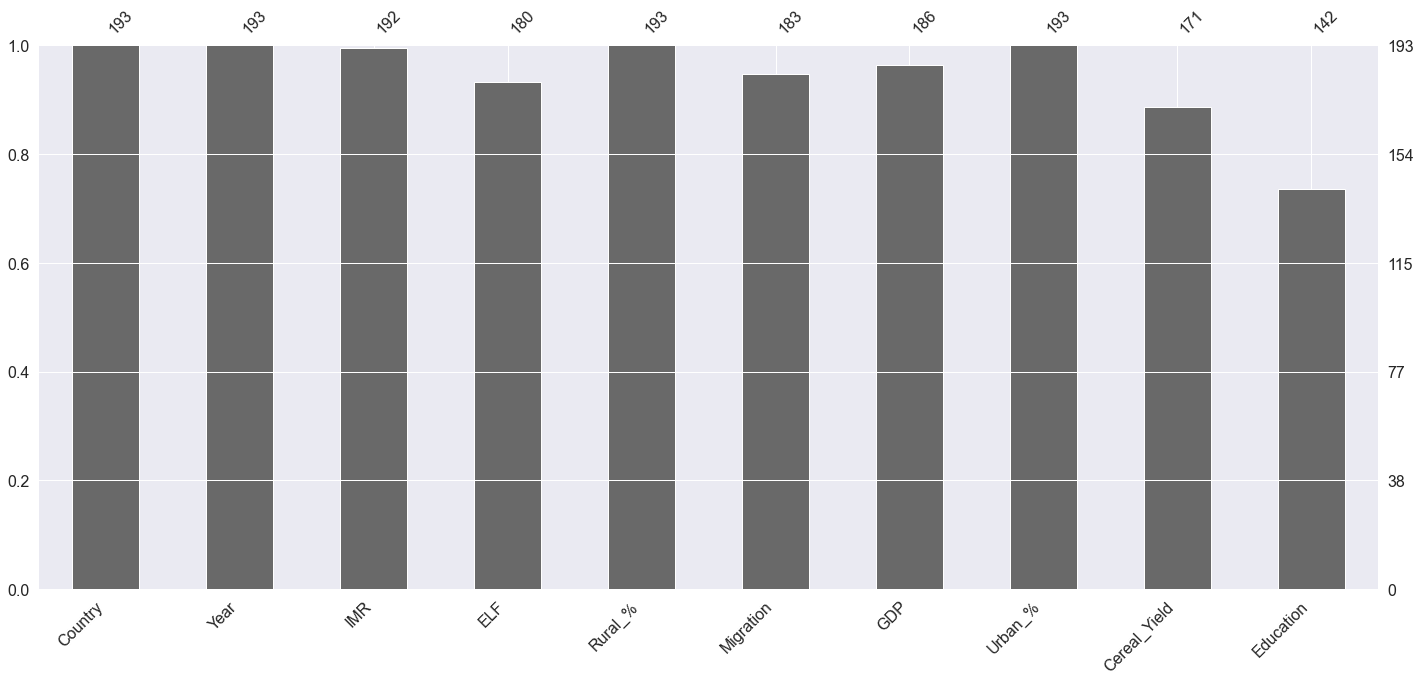

In [182]:
#Checking for Missing Values
miss.bar(frac_2001);

In [183]:
#Dropping columns
frac_2001 = frac_2001.drop(columns = ['Country', 'Year', 'Migration', 'GDP', 'Migration', 'Education', 'Urban_%'])

In [184]:
#Dropping NA values 
NA_2001 = frac_2001[~frac_2001.isna().any(axis=1)]

NA_2001.count()

IMR             163
ELF             163
Rural_%         163
Cereal_Yield    163
dtype: int64

In [185]:
#Split the data into test and training data
y = NA_2001['ELF']
X = NA_2001.drop(columns=['ELF'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = .25, random_state = 111)

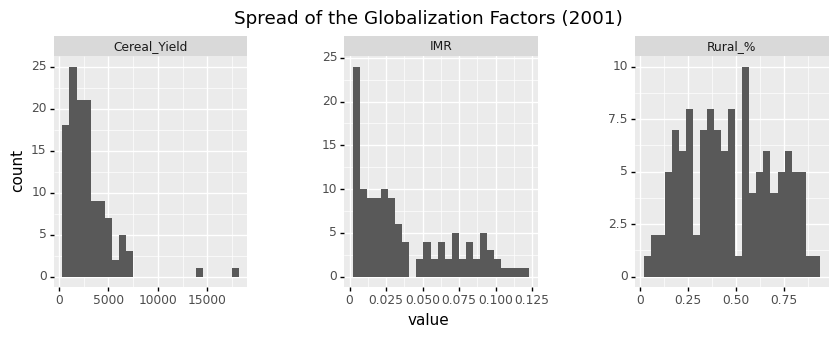

<ggplot: (320637410)>

In [186]:
# Plotted the float variables
d = train_X.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins = 25) +
    facet_wrap("variable",scales='free') +
    labs(title="Spread of the Globalization Factors (2001)") +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.5}, panel_spacing_y=0.2)
)

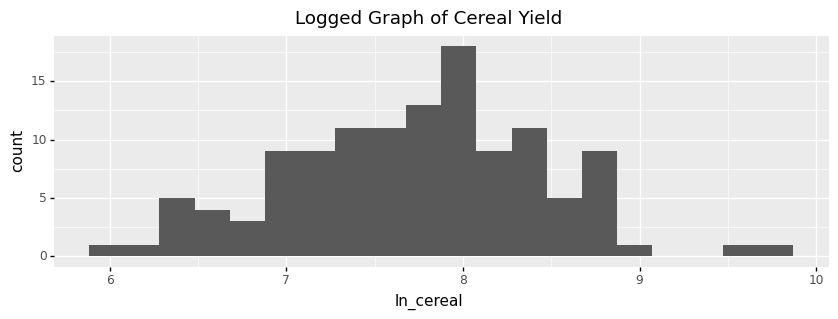

<ggplot: (302976476)>

In [187]:
#Plotted the log transformation of the Infant column
d = train_X.copy()
d['ln_cereal'] =  np.log(d['Cereal_Yield'] + 1)
(
    ggplot(d,aes(x="ln_cereal")) +
    geom_histogram(bins = 20) +
    ggtitle ("Logged Graph of Cereal Yield") +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

In [188]:
#Logged Cereal_Yield and created a new column for that value
NA_2001['ln_cereal'] =  np.log(NA_2001['Cereal_Yield'])

#Dropped the original Amount column
NA_2001 = NA_2001.drop(['Cereal_Yield'],axis=1)

In [117]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [194]:
#Created an array of all possible options
options = np.arange(110)

In [258]:
#Passed a dictionary of all the tuning parameter values that we want to explore
knn_tune_params = {'n_neighbors':options}

In [300]:
#Wrapped the model method in the GridSearchCV() class
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4)

In [301]:
#Tunned KNN
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])},
             scoring='neg_root_mean_squared_error')

In [302]:
#Best number of neighbors
tune_knn.best_params_

{'n_neighbors': 35}

In [303]:
#Wrapped the model method in the GridSearchCV() class
tune_dt = GridSearchCV(DT(),{'max_depth':[i for i in range(1500)]},
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=5)

In [304]:
#Tunned the Decision Tree
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=5,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='neg_root_mean_squared_error')

In [305]:
#Best tree depth size
tune_dt.best_params_

{'max_depth': 2}

In [306]:
#Wrapped the model method in the GridSearchCV() class
rf_params = {'max_depth':[1],
             'n_estimators':[i for i in range(50)],
              'max_features': [1,2,3]} # Only have three total.
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4)

In [307]:
#Tuned random forest
tune_rf.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1], 'max_features': [1, 2, 3],
                         'n_estimators': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='neg_root_mean_squared_error')

In [308]:
#Best parameters for random forest
tune_rf.best_params_

{'max_depth': 1, 'max_features': 2, 'n_estimators': 9}

In [309]:
#Started a pipeline
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [269]:
#Search space utilizing the best parameters from above
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1, 8, 10, 25, 30, 35, 48, 75]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT(random_state=1234)],
     'model__max_depth':[1,2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF(random_state=1234)],
    'model__max_depth':[1,2,3,4],
    'model__n_estimators':[i for i in range(50)],
    'model__max_features':[1,2,3]}
    
]

In [310]:
#Girdsearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

In [311]:
#Ran the search
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [1, 8, 10, 25, 35, 48, 75]},
                         {'model': [DecisionTreeRegressor(random_state=1234)],
                          'model__max_depth': [1, 2, 3, 4]},
                         {'model': [RandomForestRegressor(max_depth=2,
                                                          max_features=2,
                                                          n_estimators=17,
                                                          random_state=1234)],
                          'model__max_depth': [1, 2, 3, 4],
                          'model__max_features': [1, 2, 3],
                        

In [312]:
#Best score
search.best_score_

-0.23703820769665324

In [313]:
#Best parameters
search.best_params_

{'model': RandomForestRegressor(max_depth=2, max_features=2, n_estimators=17,
                       random_state=1234),
 'model__max_depth': 2,
 'model__max_features': 2,
 'model__n_estimators': 17}

In [314]:
#Labelled the best model
rmse = search.best_estimator_

In [315]:
#Ran predict on the test data to use the best model
pred_y = search.predict(test_X)

In [316]:
#Permuted the features to determine importance
vi = permutation_importance(mse,train_X,train_y,n_repeats=5)

In [317]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,IMR,0.453736,0.076412,0.300912,0.606560
1,Rural_%,0.052493,0.023247,0.006000,0.098986
2,Cereal_Yield,0.041396,0.019132,0.003131,0.079661


In [318]:
#Determined the MSE of the prediction
m.mean_squared_error(test_y,pred_y, squared=False)

0.22770233981778948

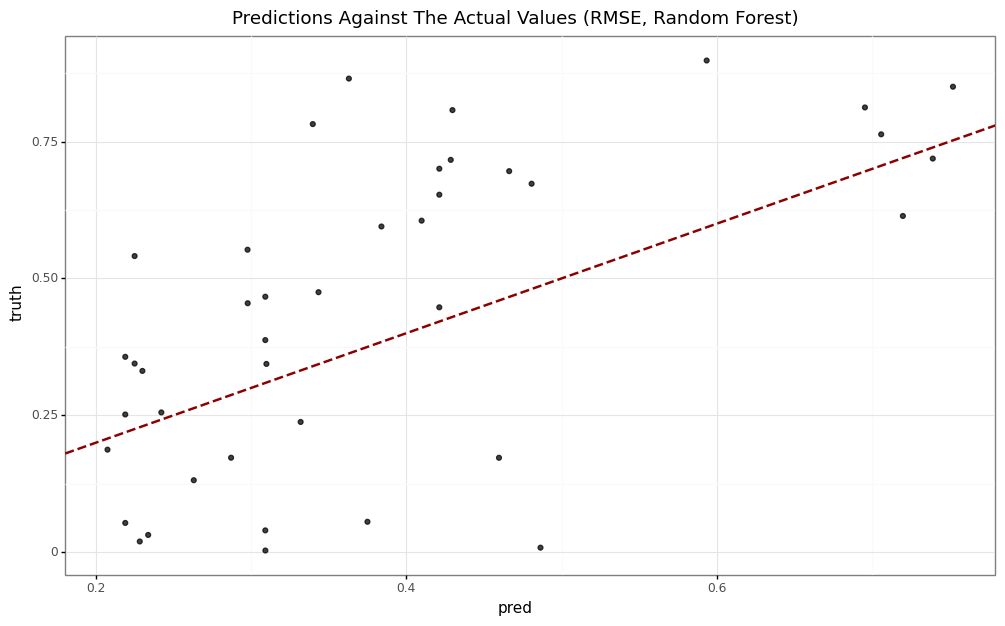

<ggplot: (320798287)>

In [320]:
#Plotted the prediction against the actual data
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(title="Predictions Against The Actual Values (RMSE, Random Forest)") +
    theme(figure_size=(12,7))
)

In [217]:
#Wrapped the model method in the GridSearchCV() class
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='r2',
                        n_jobs=4)

In [218]:
#Tunned KNN
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])},
             scoring='r2')

In [219]:
#Best number of neighbors
tune_knn.best_params_

{'n_neighbors': 35}

In [220]:
#Wrapped the model method in the GridSearchCV() class
tune_dt = GridSearchCV(DT(),{'max_depth':[i for i in range(1500)]},
                        cv = fold_generator,
                        scoring='r2',
                        n_jobs=5)

In [221]:
#Tunned the Decision Tree
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=5,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='r2')

In [222]:
#Best tree depth size
tune_dt.best_params_

{'max_depth': 2}

In [223]:
#Wrapped the model method in the GridSearchCV() class
rf_params = {'max_depth':[1],
             'n_estimators':[i for i in range(50)],
              'max_features': [1,2,3]} # Only have three total.
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='r2',
                        n_jobs=4)

In [224]:
#Tuned random forest
tune_rf.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1], 'max_features': [1, 2, 3],
                         'n_estimators': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='r2')

In [225]:
#Best parameters for random forest
tune_rf.best_params_

{'max_depth': 1, 'max_features': 2, 'n_estimators': 17}

In [250]:
#Gridsearch
search_r2 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=4)

In [251]:
#Ran the search
search_r2.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=8)],
                          'model__n_neighbors': [1, 8, 10, 25, 35, 48, 75]},
                         {'model': [DecisionTreeRegressor(random_state=1234)],
                          'model__max_depth': [1, 2, 3, 4]},
                         {'model': [RandomForestRegressor(max_depth=2,
                                                          max_features=2,
                                                          n_estimators=17,
                                                          random_state=1234)],
                          'model__max_depth': [1, 2, 3, 4],
                          'model__max_features': [1, 2, 3],
           

In [252]:
#Best score
search_r2.best_score_

0.1825861028997236

In [253]:
#Best parameters
search_r2.best_params_

{'model': KNeighborsRegressor(n_neighbors=8), 'model__n_neighbors': 8}

In [254]:
#Labelled the best model
r2 = search_r2.best_estimator_

In [255]:
#Ran predict on the test data to use the best model
pred_y = search_r2.predict(test_X)

In [256]:
#Determined the MSE of the prediction
m.r2_score(test_y,pred_y)

0.2906014562161703

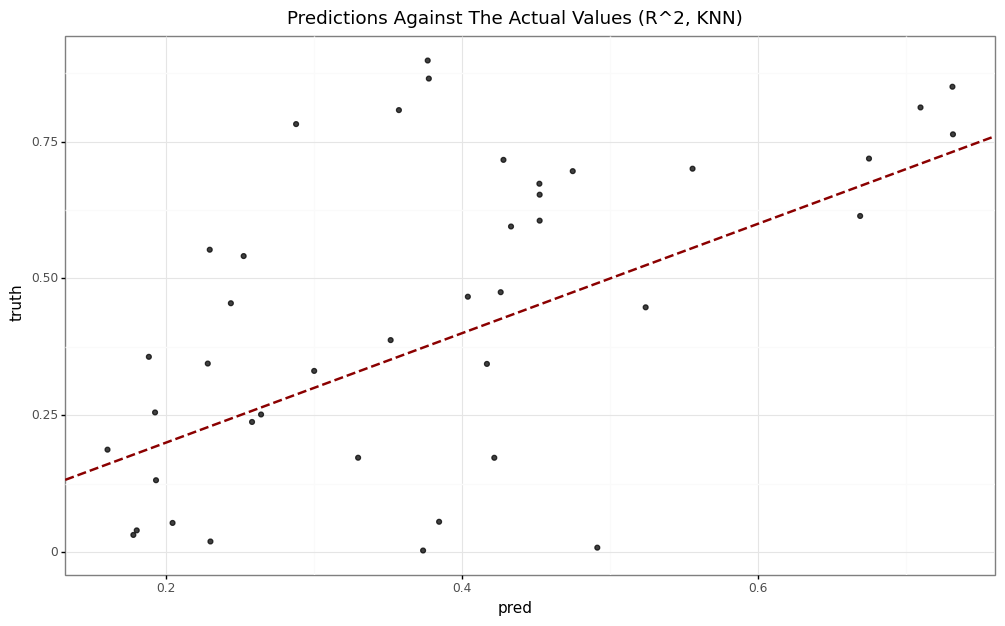

<ggplot: (320423524)>

In [257]:
#Plotted the prediction against the actual data
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(title="Predictions Against The Actual Values (R^2, KNN)") +
    theme(figure_size=(12,7))
)